In [1]:
import numpy as np
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem,get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.model.problem import Problem

In [2]:
#defining problem
class AdaptationProblem(Problem):
    """
    response times are filled based on papers values(page8-table1)
    """
    def __init__(self,
                landa=50, #arrival rate (req/s)
                n=10, #average data payload for each request (KB)
                p_i=2.64E-04, #cost of a VM ($/s)
                p_n=3.50E-06, #cost of data transfer ($/KB)
                H=8.50E-05, #static Hosting cost ($/s)
                RPM=0.7, #revenue per 1000 ads ($)
                R=100, #response time (ms)
                gamma_l=1, #gamma lower bound (gamma is average number of ad banners per page)
                gamma_u=10, #gamma upper bound
                R_l=45, # respose time lower bound
                R_u=200, # response time upper bound
                d_l=15, #capacity of each VM lower bound(request/s)
                d_u=21 #capacity of each VM upper bound(request/s)
                ): 
        self.landa = landa
        self.n = n
        self.p_i = p_i
        self.p_n = p_n
        self.H = H
        self.RPM = RPM
        self.R = R
        self.gamma_l = gamma_l
        self.gamma_u = gamma_u
        self.R_l = R_l
        self.R_u = R_u
        self.d_l = d_l
        self.d_u = d_u
        #weights in user satisfaction formula
        self.a = 0.5
        self.b = 0.5
        #p_s doesn't have any bound so we should feed algorithm 
        #a very high number for upper bound and 0 (logically) for lower bound
        super().__init__(n_var=3, #p_s,W,gamma
                         n_obj=3, #pi_s,pi_a,U
                         n_constr=4,
                         xl=np.array([0,landa/d_u,gamma_l]),
                         xu=np.array([10000,landa/d_l,gamma_u]))

    def _evaluate(self, x, out, *args, **kwargs):
        #objectives
        #to maximize objectives we multipy them by -1 and then minimize them 
        #objectives are not normalized. test normalization on results
        d = self.landa/x[:,1]
        rel_d = (d - self.d_l) / (self.d_u - self.d_l)
        R = ((self.R_u-self.R_l)*rel_d) + self.R_l
        pi_s = x[:,0]*self.landa - self.p_i*x[:,1] - self.n*self.p_n*self.landa
        pi_a = (x[:,2]*self.RPM/1000)*self.landa - self.H*self.landa - x[:,0]*self.landa
        U = self.a*((self.gamma_u-x[:,2])/(self.gamma_u-self.gamma_l)) + self.b*((self.R_u-R)/(self.R_u-self.R_l))
        
        out["F"] = np.column_stack([-1*pi_s, -1*pi_a,-1*U])
            
        #constrains (equations are filped in a way that they would be less than zero)
        g1 = x[:,0] - (x[:,2]*self.RPM/1000)
        g2 = -1*(pi_s)
        g3 = -1*(pi_a)
        g4 = (0.8 - U)

        out["G"] = np.column_stack([g1, g2, g3, g4])


In [3]:
#defining algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



In [4]:
#defining termination
termination = get_termination('n_gen',130)

In [5]:
#running minimize problem
problem = AdaptationProblem()

res = minimize(problem,
               algorithm,
               termination,
               save_history=True,
               verbose=True
              )

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |  2.25715E+03 |  2.38242E+05 |       1 |            - |            - |            -
    2 |     110 |  2.25715E+03 |  2.03220E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    3 |     120 |  2.25715E+03 |  1.77193E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    4 |     130 |  7.89814E+02 |  1.54372E+05 |       1 |  1.43837E+03 |  1.43837E+03 |  2.03414E+33
    5 |     140 |  7.89814E+02 |  1.36213E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    6 |     150 |  7.89814E+02 |  1.16290E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    7 |     160 |  7.89814E+02 |  9.86878E+04 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    8 |     170 |  7.89814E+02 |  8.36049E+04 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    9 |     180 |  7.89814E+02 |  7.10416E+04 |       1 |  0.00000E+00 |  0.00000E+00 |  0.

   89 |     980 |  0.00000E+00 |  0.064566382 |       1 |  0.033942222 |  0.033942222 |  3.50786E+28
   90 |     990 |  0.00000E+00 |  0.061930149 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
   91 |    1000 |  0.00000E+00 |  0.058693532 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
   92 |    1010 |  0.00000E+00 |  0.055300320 |       2 |  1.000000000 |  1.000000000 |  0.866025404
   93 |    1020 |  0.00000E+00 |  0.052036014 |       3 |  0.398441420 |  0.999088091 |  0.487879547
   94 |    1030 |  0.00000E+00 |  0.049218844 |       3 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
   95 |    1040 |  0.00000E+00 |  0.046180644 |       3 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
   96 |    1050 |  0.00000E+00 |  0.043920441 |       4 |  0.273106021 |  0.00000E+00 |  0.140813837
   97 |    1060 |  0.00000E+00 |  0.041569438 |       5 |  0.00000E+00 |  0.435849803 |  0.174401738
   98 |    1070 |  0.00000E+00 |  0.039211863 |       5 |  0.00000E+00 |  0.00000E+00 |  0.

AttributeError: 'Axes3D' object has no attribute 'xlabel'

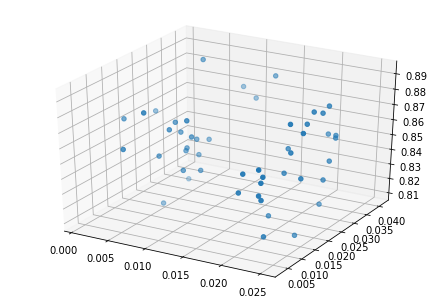

In [9]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)
f = -1*res.F

sequence_containing_x_vals = f[:,0]
sequence_containing_y_vals = f[:,1]
sequence_containing_z_vals = f[:,2]

random.shuffle(sequence_containing_x_vals)
random.shuffle(sequence_containing_y_vals)
random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

In [213]:
# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]


In [214]:
X = np.array([pop.get("X") for pop in pop_each_gen])
G = np.array([pop.get("G") for pop in pop_each_gen])
F = np.array([pop.get("F") for pop in pop_each_gen])

In [227]:
gen = 129

Text(0, 0.5, '-pi_s')

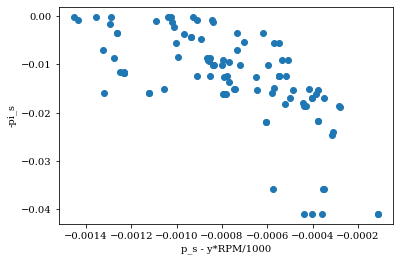

In [228]:
plt.scatter(G[gen][:,0],G[gen][:,1])
plt.xlabel("p_s - y*RPM/1000")
plt.ylabel("-pi_s")

Text(0, 0.5, '0.8-U')

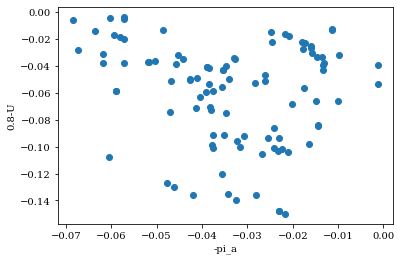

In [229]:
plt.scatter(G[gen][:,2],G[gen][:,3])
plt.xlabel("-pi_a")
plt.ylabel("0.8-U")

Text(0, 0.5, 'W')

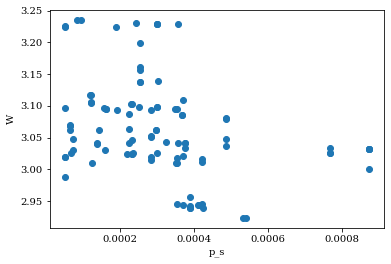

In [230]:
plt.scatter(X[gen][:,0],X[gen][:,1])
plt.xlabel("p_s")
plt.ylabel("W")

Text(0, 0.5, 'gamma')

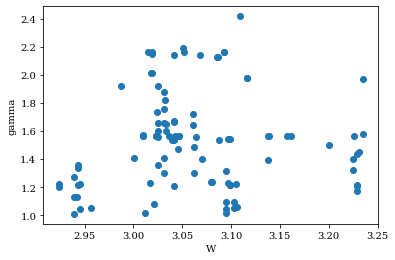

In [231]:
plt.scatter(X[gen][:,1],X[gen][:,2])
plt.xlabel("W")
plt.ylabel("gamma")

In [173]:
pr = AdaptationProblem(landa=250,n=0.1,R_l=1,R_u=200,d_l=10,d_u=200)

In [174]:
res = minimize(pr,
               algorithm,
               termination,
               save_history=True,
               verbose=True
              )

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |  3.07085E+04 |  1.27245E+06 |       1 |            - |            - |            -
    2 |     110 |  3.07085E+04 |  1.10261E+06 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    3 |     120 |  3.07085E+04 |  9.87995E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    4 |     130 |  3.07085E+04 |  8.73928E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    5 |     140 |  3.07085E+04 |  7.80080E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    6 |     150 |  9.93616E+03 |  6.80111E+05 |       1 |  2.06901E+04 |  2.06901E+04 |  2.92598E+34
    7 |     160 |  9.93616E+03 |  5.95757E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    8 |     170 |  9.93616E+03 |  5.23672E+05 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    9 |     180 |  9.93615E+03 |  4.62741E+05 |       1 |  0.017115468 |  0.017115468 |  1.

  109 |    1180 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.046369838 |  0.002824228
  110 |    1190 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.001536702
  111 |    1200 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.000578334
  112 |    1210 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.001137134
  113 |    1220 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000907198 |  0.00000E+00 |  0.002535178
  114 |    1230 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.002415723
  115 |    1240 |  0.00000E+00 |  0.00000E+00 |     100 |  0.003513757 |  0.00000E+00 |  0.001390960
  116 |    1250 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.002555013
  117 |    1260 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.003065767
  118 |    1270 |  0.00000E+00 |  0.00000E+00 |     100 |  0.00000E+00 |  0.00000E+00 |  0.

In [243]:

def choose_on_pf(pareto_f,design_space,w_s=0.33,w_a=0.33,w_u=0.33):
    max_values = np.max(pareto_f,axis=0)
    arg_max = np.argmax(pareto_f[:,0]*w_s/max_values[0] + pareto_f[:,1]*w_a/max_values[1] + pareto_f[:,2]*w_u/max_values[2])
    return tuple(design_space[arg_max])

In [245]:
p_s , W , gamma = choose_on_pf(-1*res.F,res.X)

2.4170121276213963